In [54]:
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt, matplotlib.cm as cm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import linear_sum_assignment
from collections import defaultdict

In [3]:

from google.colab import drive
drive.mount('/content/drive')

ROOT_DIR  = "/content/drive/MyDrive/TP 3 biomed"

TRAIN_ROOT = os.path.join(ROOT_DIR, "train")
TEST_ROOT  = os.path.join(ROOT_DIR, "test")

IMG_SIZE = 256

Mounted at /content/drive


In [46]:


BATCH_SIZE = 8
LR         = 1e-3
EPOCHS     = 40
THRESH     = 0.5
MIN_AREA   = 30

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)



Device: cuda


In [47]:

class CTCTrainDataset(Dataset):
    def __init__(self, root, img_size=256):
        self.img_size = img_size
        self.image_paths = []
        self.mask_paths  = []

        for seq in ["01", "02"]:
            img_dir = os.path.join(root, seq)
            seg_dir = os.path.join(root, f"{seq}_GT", "SEG")

            mask_files = sorted(glob.glob(os.path.join(seg_dir, "man_seg*.tif")))
            if len(mask_files) == 0:
                print(f"[WARN] Aucun masque dans {seg_dir}")

            for m_path in mask_files:
                base = os.path.basename(m_path)              # man_seg012.tif
                idx = base.replace("man_seg", "").replace(".tif", "")  # "012"
                img_name = f"t{idx}.tif"                     # t012.tif
                img_path = os.path.join(img_dir, img_name)

                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(m_path)
                else:
                    print(f"[WARN] image manquante pour {m_path} -> {img_name}")

        assert len(self.image_paths) == len(self.mask_paths), \
            "Nombre d'images et masques différent !"
        print(f"Train samples: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path  = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img  = cv2.imread(img_path,  cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        img  = cv2.resize(img,  (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size),
                          interpolation=cv2.INTER_NEAREST)

        img  = img.astype(np.float32)
        img  = (img - img.mean()) / (img.std() + 1e-8)

        # GT CTC: labels >0 => cellule
        mask = (mask > 0).astype(np.float32)

        img_tensor  = torch.from_numpy(img).unsqueeze(0)   # (1,H,W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)  # (1,H,W)
        return img_tensor, mask_tensor



class SimpleImageFolder(Dataset):
    def __init__(self, img_dir, img_size=256):
        self.img_size = img_size
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "t*.tif")))
        print(f"{img_dir} -> {len(self.img_paths)} images")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img  = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        img  = cv2.resize(img, (self.img_size, self.img_size))

        img  = img.astype(np.float32)
        img  = (img - img.mean()) / (img.std() + 1e-8)

        img_tensor = torch.from_numpy(img).unsqueeze(0)
        return img_tensor, path



In [23]:



# ============================================================
# U-NET
# ============================================================

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_ch=32):
        super().__init__()
        self.down1 = DoubleConv(in_channels, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(base_ch*4, base_ch*8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base_ch*8, base_ch*16)

        self.up4  = nn.ConvTranspose2d(base_ch*16, base_ch*8, 2, stride=2)
        self.dec4 = DoubleConv(base_ch*16, base_ch*8)
        self.up3  = nn.ConvTranspose2d(base_ch*8, base_ch*4, 2, stride=2)
        self.dec3 = DoubleConv(base_ch*8, base_ch*4)
        self.up2  = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.dec2 = DoubleConv(base_ch*4, base_ch*2)
        self.up1  = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.dec1 = DoubleConv(base_ch*2, base_ch)

        self.out_conv = nn.Conv2d(base_ch, out_channels, 1)

    def forward(self, x):
        c1 = self.down1(x); p1 = self.pool1(c1)
        c2 = self.down2(p1); p2 = self.pool2(c2)
        c3 = self.down3(p2); p3 = self.pool3(c3)
        c4 = self.down4(p3); p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        c5 = self.dec4(u4)

        u3 = self.up3(c5)
        u3 = torch.cat([u3, c3], dim=1)
        c6 = self.dec3(u3)

        u2 = self.up2(c6)
        u2 = torch.cat([u2, c2], dim=1)
        c7 = self.dec2(u2)

        u1 = self.up1(c7)
        u1 = torch.cat([u1, c1], dim=1)
        c8 = self.dec1(u1)

        return self.out_conv(c8)


In [24]:


# ============================================================
# LOSS (BCE + DICE)
# ============================================================

def dice_coeff(pred, target, eps=1e-6):
    pred = pred.contiguous().view(pred.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)
    inter = (pred * target).sum(dim=1)
    denom = pred.sum(dim=1) + target.sum(dim=1) + eps
    return ((2 * inter + eps) / denom).mean()


class BCEDiceLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        dice_loss = 1 - dice_coeff(probs, targets)
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss


In [48]:

# ============================================================
# TRAINING
# ============================================================

def train_model():
    dataset = CTCTrainDataset(TRAIN_ROOT, img_size=IMG_SIZE)
    loader  = DataLoader(dataset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=0)

    model = UNet(in_channels=1, out_channels=1, base_ch=32).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    crit  = BCEDiceLoss(alpha=0.5)

    model.train()
    for epoch in range(1, EPOCHS+1):
        running = 0.0
        for imgs, masks in loader:
            imgs  = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            optim.zero_grad()
            logits = model(imgs)
            loss = crit(logits, masks)
            loss.backward()
            optim.step()

            running += loss.item() * imgs.size(0)

        epoch_loss = running / len(dataset)
        print(f"Epoch {epoch}/{EPOCHS} - Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), "unet_cell_seg.pth")
    print("Modèle sauvegardé: unet_cell_seg.pth")
    return model


In [49]:
# ======================= SEGMENTATION =======================

def segment_sequence_simple(model, img_dir, img_size=256, thresh=0.1):
    model.eval()
    ds = SimpleImageFolder(img_dir, img_size=img_size)
    loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0)

    instance_masks, img_paths = [], []
    with torch.no_grad():
        for img_t, path in loader:
            img_t = img_t.to(DEVICE)
            logits = model(img_t)
            prob   = torch.sigmoid(logits)[0,0].cpu().numpy()
            bin_mask = (prob > thresh).astype(np.uint8)
            num_labels, labels = cv2.connectedComponents(bin_mask)
            instance_masks.append(labels.astype(np.int32))
            img_paths.append(path[0])
    return instance_masks, img_paths

In [50]:
# ======================= TRACKING =======================

def mask_to_props(label_img):
    props = {}
    labels = np.unique(label_img)
    for lbl in labels:
        if lbl == 0:
            continue
        ys, xs = np.where(label_img == lbl)
        if len(xs) == 0:
            continue
        props[lbl] = {"centroid": (xs.mean(), ys.mean())}
    return props


def iou_masks(mask_a, mask_b, id_a, id_b):
    A = (mask_a == id_a)
    B = (mask_b == id_b)
    inter = np.logical_and(A, B).sum()
    union = np.logical_or(A, B).sum()
    return 0.0 if union == 0 else inter / union


def track_instances(instance_masks, max_dist=20.0, w_d=0.5, w_iou=0.5, max_cost=0.8):
    tracked_masks = []
    next_id = 1

    first = instance_masks[0]
    trk   = np.zeros_like(first, dtype=np.int32)
    props0 = mask_to_props(first)
    for lbl in props0:
        trk[first == lbl] = next_id
        next_id += 1
    tracked_masks.append(trk)

    for t in range(1, len(instance_masks)):
        prev = tracked_masks[-1]
        curr = instance_masks[t]

        prev_ids = [i for i in np.unique(prev) if i != 0]
        curr_lbls = [i for i in np.unique(curr) if i != 0]

        prev_props = {}
        for tid in prev_ids:
            ys, xs = np.where(prev == tid)
            if len(xs) == 0:
                continue
            prev_props[tid] = {"centroid": (xs.mean(), ys.mean())}

        curr_props = mask_to_props(curr)

        if len(prev_props) == 0 or len(curr_props) == 0:
            trk_img = np.zeros_like(curr, dtype=np.int32)
            for lbl in curr_lbls:
                trk_img[curr == lbl] = next_id
                next_id += 1
            tracked_masks.append(trk_img)
            continue

        prev_ids = list(prev_props.keys())
        curr_lbls = list(curr_props.keys())
        cost_matrix = np.zeros((len(prev_ids), len(curr_lbls)), dtype=np.float32)

        for i, tid in enumerate(prev_ids):
            cx1, cy1 = prev_props[tid]["centroid"]
            for j, lbl in enumerate(curr_lbls):
                cx2, cy2 = curr_props[lbl]["centroid"]
                dist = np.sqrt((cx1 - cx2)**2 + (cy1 - cy2)**2)
                dist_norm = min(dist / max_dist, 1.0)
                iou = iou_masks(prev, curr, tid, lbl)
                cost = w_d * dist_norm + w_iou * (1 - iou)
                cost_matrix[i, j] = cost

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        trk_img = np.zeros_like(curr, dtype=np.int32)
        used_curr = set()

        for r, c in zip(row_ind, col_ind):
            if cost_matrix[r, c] > max_cost:
                continue
            tid = prev_ids[r]
            lbl = curr_lbls[c]
            trk_img[curr == lbl] = tid
            used_curr.add(lbl)

        for lbl in curr_lbls:
            if lbl not in used_curr:
                trk_img[curr == lbl] = next_id
                next_id += 1

        tracked_masks.append(trk_img)

    return tracked_masks

    return tracked_masks

In [51]:
# ======================= VISUALISATION =======================

def show_test_prediction(model, seq="01", frame_idx=0, thresh=0.1):
    img_dir = os.path.join(TEST_ROOT, seq)
    ds = SimpleImageFolder(img_dir, img_size=IMG_SIZE)
    img_t, path = ds[frame_idx]
    img_np = img_t.squeeze(0).numpy()

    with torch.no_grad():
        inp = img_t.unsqueeze(0).to(DEVICE)
        logits = model(inp)
        prob = torch.sigmoid(logits)[0,0].cpu().numpy()

    bin_mask = (prob > thresh).astype(np.uint8)
    img_norm = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    plt.figure(figsize=(14,4))
    plt.subplot(1,4,1); plt.imshow(img_norm, cmap="gray"); plt.title("Image"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(prob, cmap="viridis"); plt.title("Proba"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(bin_mask, cmap="gray"); plt.title(f"Mask (th={thresh})"); plt.axis("off")
    plt.subplot(1,4,4)
    plt.imshow(img_norm, cmap="gray")
    plt.imshow(bin_mask, cmap="jet", alpha=0.4)
    plt.title("Overlay"); plt.axis("off")
    plt.tight_layout(); plt.show()

def show_tracking_frame(tracked_masks, img_paths, frame_idx=0):
    track_img = tracked_masks[frame_idx]
    img_path  = img_paths[frame_idx]

    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img.ndim == 3: img = img[...,0]
    h, w = track_img.shape
    img = cv2.resize(img, (w, h)).astype(np.float32)
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_norm, cmap="gray"); plt.title(os.path.basename(img_path)); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(track_img, cmap="nipy_spectral"); plt.title("Tracking"); plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img_norm, cmap="gray")
    plt.imshow(track_img, cmap="nipy_spectral", alpha=0.5)
    plt.title("Overlay"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [52]:
# ---- figures résumées ----

def compute_track_centers(tracked_masks):
    tracks = defaultdict(list)
    for t, mask in enumerate(tracked_masks):
        ids = np.unique(mask)
        for tid in ids:
            if tid == 0: continue
            ys, xs = np.where(mask == tid)
            if len(xs) == 0: continue
            tracks[int(tid)].append((t, ys.mean(), xs.mean()))
    return tracks


def plot_tracking_snapshots(tracked_masks, img_paths, frame_indices, nrows=2, ncols=3):
    tracks = compute_track_centers(tracked_masks)
    all_ids = sorted(tracks.keys())
    if not all_ids: return
    cmap = cm.get_cmap("nipy_spectral")
    max_id = max(all_ids)

    fig, axes = plt.subplots(nrows, ncols, figsize=(15,7))
    axes = axes.ravel()

    for ax_idx, t in enumerate(frame_indices):
        if t >= len(tracked_masks):
            axes[ax_idx].axis("off"); continue

        mask_t = tracked_masks[t]
        img_path = img_paths[t]
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img.ndim == 3: img = img[...,0]
        h, w = mask_t.shape
        img = cv2.resize(img, (w, h)).astype(np.float32)
        img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)

        ax = axes[ax_idx]
        ax.imshow(img_norm, cmap="gray")

        ids_t = [i for i in np.unique(mask_t) if i != 0]
        for tid in all_ids:
            pts = [p for p in tracks[tid] if p[0] <= t]
            if len(pts) < 2: continue
            pts = sorted(pts, key=lambda p: p[0])
            ys = [p[1] for p in pts]
            xs = [p[2] for p in pts]
            color = cmap(tid / max_id)
            ax.plot(xs, ys, '-', color=color, linewidth=1)
            if pts[-1][0] == t:
                ax.plot(xs[-1], ys[-1], 'o', color=color, markersize=3)

        ax.set_title(f"Frame {t} - {len(ids_t)} cells", fontsize=10)
        ax.axis("off")

    for k in range(len(frame_indices), nrows*ncols):
        axes[k].axis("off")

    plt.tight_layout(); plt.show()


def plot_longest_trajectories(tracked_masks, img_paths, top_k=20, title=None):
    tracks = compute_track_centers(tracked_masks)
    if not tracks: return
    lengths = {tid: len(pts) for tid, pts in tracks.items()}
    sorted_ids = sorted(lengths.keys(), key=lambda k: lengths[k], reverse=True)
    selected_ids = sorted_ids[:top_k]

    h, w = tracked_masks[0].shape
    stack = []
    for p in img_paths:
        img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
        if img.ndim == 3: img = img[...,0]
        img = cv2.resize(img, (w, h)).astype(np.float32)
        stack.append(img)
    stack = np.stack(stack, axis=0)
    bg = np.median(stack, axis=0)
    bg_norm = (bg - bg.min()) / (bg.max() - bg.min() + 1e-8)
    bg_gray = 0.7 * bg_norm + 0.3
    bg_rgb = np.stack([bg_gray]*3, axis=-1)

    cmap = cm.get_cmap("tab20")
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(bg_rgb)

    handles = []
    for i, tid in enumerate(selected_ids):
        pts = sorted(tracks[tid], key=lambda p: p[0])
        ys = [p[1] for p in pts]
        xs = [p[2] for p in pts]
        color = cmap(i % 20)
        line, = ax.plot(xs, ys, '-', color=color, linewidth=2, label=f"Cell {tid}")
        handles.append(line)

    ax.set_axis_off()
    if title is None:
        title = f"Top {len(selected_ids)} longest cell trajectories over {len(tracked_masks)} frames"
    ax.set_title(title, fontsize=12)
    ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02,0.5),
              frameon=False, fontsize=8)
    plt.tight_layout(); plt.show()

/content/drive/MyDrive/TP 3 biomed/test/02 -> 92 images
/content/drive/MyDrive/TP 3 biomed/test/02 -> 92 images


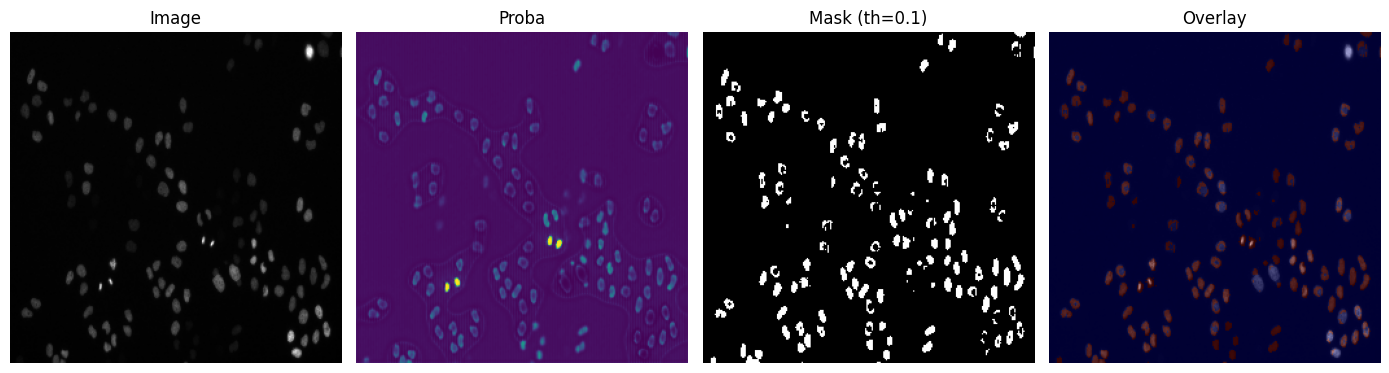

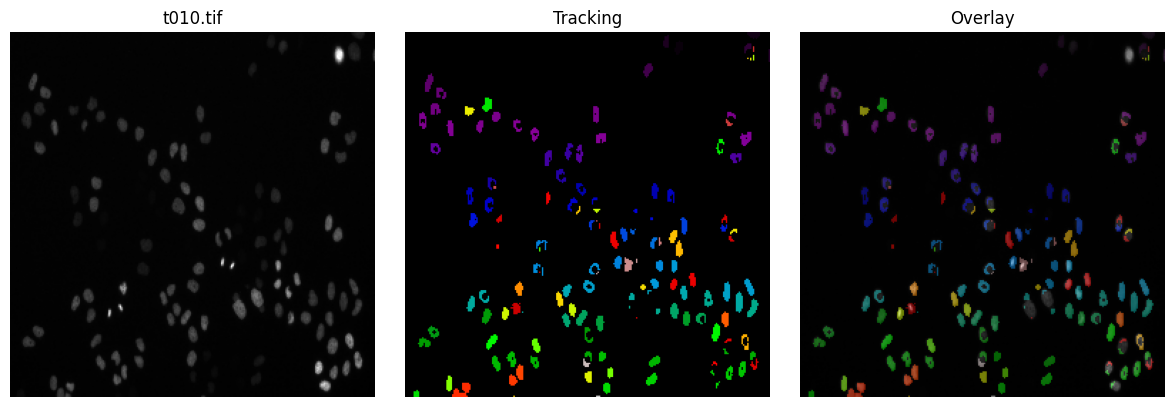

/tmp/ipython-input-587102984.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("nipy_spectral")


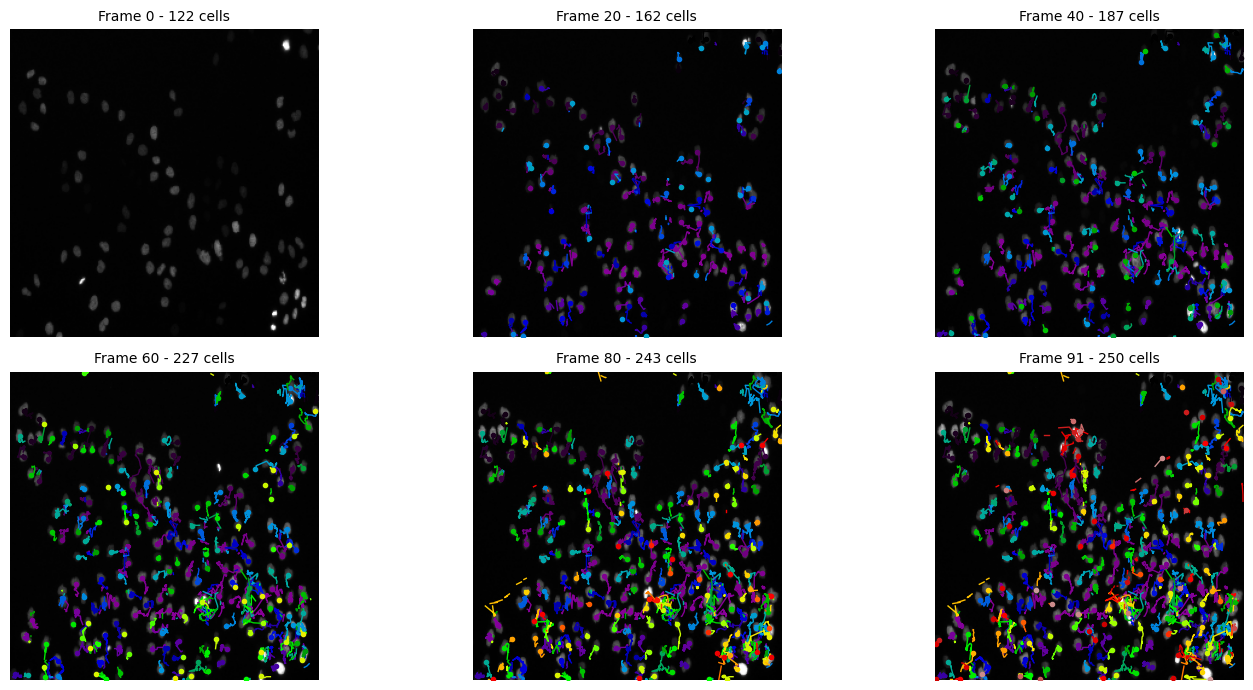

/tmp/ipython-input-587102984.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")


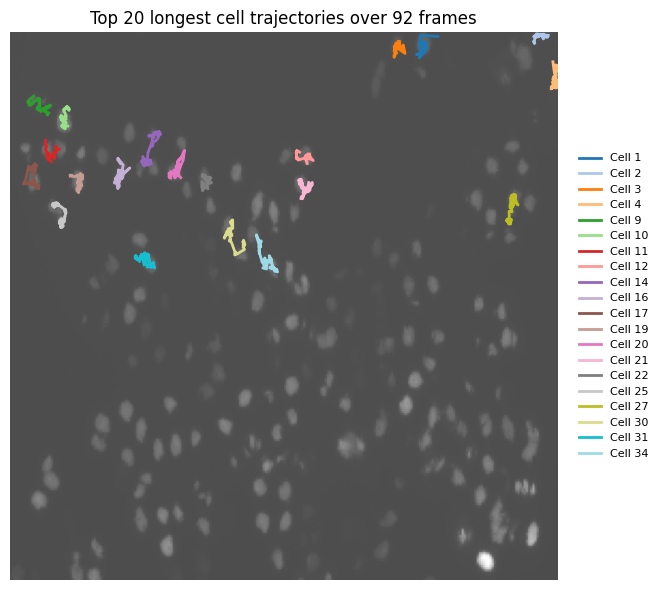

In [53]:
# 1) entraîner ou charger
# model = train_model()
model = UNet().to(DEVICE)
model.load_state_dict(torch.load("unet_cell_seg.pth", map_location=DEVICE))

# 2) segmentation + tracking sur une séquence
seq = "02"
img_dir = os.path.join(TEST_ROOT, seq)
inst_masks, img_paths = segment_sequence_simple(model, img_dir, img_size=IMG_SIZE, thresh=0.1)
tracked = track_instances(inst_masks)

# 3) visualisations
show_test_prediction(model, seq="02", frame_idx=10, thresh=0.1)
show_tracking_frame(tracked, img_paths, frame_idx=10)

frame_indices = [0, 20, 40, 60, 80, 91]
plot_tracking_snapshots(tracked, img_paths, frame_indices, nrows=2, ncols=3)

plot_longest_trajectories(tracked, img_paths, top_k=20)
